In [38]:
import numpy as np
from jesse import helpers, research

_, trading_1m = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2020-01-01"),
    helpers.date_to_timestamp("2025-01-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(trading_1m.shape)

np.save("data/btc_1m.npy", trading_1m)

(2630880, 6)


In [39]:
import numpy as np

candles = np.load("data/btc_1m.npy")
print(candles.shape)
candles[0, 0]


(2630880, 6)


1577836800000.0

In [40]:
import pandas as pd
from jesse.utils import numpy_candles_to_dataframe

df = numpy_candles_to_dataframe(candles)

df["label"] = np.log(df["close"].shift(-1) / df["close"])

df["hlr"] = np.log(df["high"] / df["low"])
ret_list = []
for i in range(1, 150):
    ret_series = np.abs(np.log(df["close"] / df["close"].shift(i)))
    ret_series.name = f"abs_r{i}"
    ret_list.append(ret_series)

df = pd.concat([df, pd.concat(ret_list, axis=1)], axis=1)
del ret_list
df = df[df["abs_r149"].notna()]
df = df[(df["hlr"] > 0) & (df["abs_r1"] > 0)]

del candles
print(df.shape)

for i in range(1, 150):
    if (df[f"abs_r{i}"] == 1).sum() > 0:
        print(f"abs_r{i}: {(df[f'abs_r{i}'] == 1).sum()}")

df.head()


(2584959, 157)


,date,open,close,high,low,volume,label,hlr,abs_r1,abs_r2,...,abs_r140,abs_r141,abs_r142,abs_r143,abs_r144,abs_r145,abs_r146,abs_r147,abs_r148,abs_r149
2020-01-01 02:29:00,2020-01-01 02:29:00,7233.19,7228.09,7233.57,7225.76,7.972429,0.000664,0.001080,0.000774,0.000790,...,0.005135,0.005606,0.006166,0.006397,0.006677,0.006706,0.005848,0.006337,0.006114,0.005746
2020-01-01 02:30:00,2020-01-01 02:30:00,7227.12,7232.89,7233.14,7226.79,4.631254,-0.000192,0.000878,0.000664,0.000111,...,0.006315,0.005799,0.006270,0.006830,0.007061,0.007341,0.007370,0.006512,0.007001,0.006778
2020-01-01 02:31:00,2020-01-01 02:31:00,7232.35,7231.50,7233.84,7229.47,13.106277,0.000176,0.000604,0.000192,0.000472,...,0.005935,0.006123,0.005607,0.006078,0.006637,0.006869,0.007148,0.007178,0.006320,0.006809
2020-01-01 02:32:00,2020-01-01 02:32:00,7231.69,7232.77,7233.14,7229.78,18.132154,-0.000151,0.000465,0.000176,0.000017,...,0.006345,0.006110,0.006298,0.005782,0.006254,0.006813,0.007044,0.007324,0.007353,0.006496
2020-01-01 02:33:00,2020-01-01 02:33:00,7232.06,7231.68,7236.07,7230.19,10.299170,0.000426,0.000813,0.000151,0.000025,...,0.006882,0.006195,0.005960,0.006147,0.005631,0.006103,0.006662,0.006893,0.007173,0.007203


In [41]:
data_check = np.load("data/btc_1m.npy")
hlr_check = np.abs(np.log(data_check[:, 3] / data_check[:, 4]))
r1_check = np.abs(np.log(data_check[1:, 2] / data_check[:-1, 2]))

data_check = data_check[149:]
hlr_check = hlr_check[149:]
r1_check = r1_check[149 - 1 :]

data_check = data_check[(hlr_check > 0) & (r1_check > 0)]

assert data_check.shape[0] == df.shape[0]

In [34]:
# from custom_indicators.utils.plot import find_kde_cross

# target = np.log(df["close"] / df["close"].shift(149)).dropna()
# roots = find_kde_cross(target)


In [35]:
# label = (df["abs_r1p149"] >= 1.026490246399058236).astype(int)
# label.name = "label"
# label.sort_index(inplace=True)
# label.value_counts()

In [42]:
import warnings

from gplearn.fitness import make_fitness
from gplearn.genetic import SymbolicRegressor
from scipy import stats

from custom_indicators.toolbox.bar.build import (
    build_bar_by_threshold_greater_than,
    build_bar_by_threshold_less_than,
)


def gp_kurtosis(y, y_pred, w):
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    MIN_LENGTH = 1500

    if len(y_pred) <= 2:
        return 1000

    candles_in_metrics = np.load("data/btc_1m.npy")
    h1r = np.abs(np.log(candles_in_metrics[:, 3] / candles_in_metrics[:, 4]))
    r1 = np.abs(np.log(candles_in_metrics[1:, 2] / candles_in_metrics[:-1, 2]))
    candles_in_metrics = candles_in_metrics[149:]
    h1r = h1r[149:]
    r1 = r1[149 - 1 :]
    candles_in_metrics = candles_in_metrics[(h1r > 0) & (r1 > 0)]
    candles_in_metrics = candles_in_metrics[:-1]

    assert len(candles_in_metrics) == len(y_pred), (
        f"{len(candles_in_metrics)} != {len(y_pred)}"
    )
    # sigmoid y_pred
    y_pred = 1 / (1 + np.exp(-y_pred))

    if all(y_pred > 0.5) or all(y_pred < 0.5):
        return 1000

    merged_bar_1 = build_bar_by_threshold_greater_than(
        candles_in_metrics,
        y_pred,
        0.5,
        reverse=False,
    )

    merged_bar_2 = build_bar_by_threshold_less_than(
        candles_in_metrics,
        y_pred,
        0.5,
        reverse=True,
    )

    if len(merged_bar_1) < MIN_LENGTH and len(merged_bar_2) < MIN_LENGTH:
        return 1000
    elif len(merged_bar_1) < MIN_LENGTH:
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return kurtosis_2
    elif len(merged_bar_2) < MIN_LENGTH:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        return kurtosis_1
    else:
        log_ret_1 = np.log(merged_bar_1[1:, 2] / merged_bar_1[:-1, 2])
        std_log_ret_1 = (log_ret_1 - log_ret_1.mean()) / log_ret_1.std()
        kurtosis_1 = stats.kurtosis(std_log_ret_1)
        log_ret_2 = np.log(merged_bar_2[1:, 2] / merged_bar_2[:-1, 2])
        std_log_ret_2 = (log_ret_2 - log_ret_2.mean()) / log_ret_2.std()
        kurtosis_2 = stats.kurtosis(std_log_ret_2)
        return min(kurtosis_1, kurtosis_2)


custom_kurtosis_loss = make_fitness(
    function=gp_kurtosis,
    greater_is_better=False,
    wrap=True,
)

cols = ["hlr"] + [f"abs_r{i}" for i in range(1, 150)]

est_gp = SymbolicRegressor(
    init_method="full",
    metric=custom_kurtosis_loss,
    population_size=10000,
    generations=20,
    tournament_size=50,
    stopping_criteria=0,
    function_set=["add", "sub", "abs", "neg", "max", "min", "sqrt", "log"],
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.1,
    p_point_mutation=0.1,
    max_samples=1,
    parsimony_coefficient=0.007,
    feature_names=cols,
    verbose=1,
    n_jobs=10,
    # random_state=233,
)

label = df["label"]

est_gp.fit(df[cols].iloc[:-1], label.iloc[:-1])

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    15.56          227.845       19          10.3172              N/A    117.38m
   1    18.63          133.531       16           9.1297              N/A    109.17m
   2    18.72          124.294       33          7.56412              N/A    102.86m
   3    22.52          125.087       37          6.59325              N/A     99.52m
   4    27.27          119.095       45          6.24002              N/A     98.36m
   5    31.18          128.762       52          6.21851              N/A     94.78m
   6    33.17          127.516       36          5.64014              N/A     86.69m
   7    35.73          112.062       38          5.60756              N/A     84.11m
   8    31.46          126.756       18          5.39427              N/A  

KeyboardInterrupt: 

In [43]:
import pandas as pd

fitness_list = []
program_len_list = []
program_list = []

for lst in est_gp._programs:
    for program in lst:
        if program and program.fitness_ < 10:
            fitness_list.append(program.fitness_)
            program_len_list.append(len(str(program)))
            program_list.append(str(program))

df_res = pd.DataFrame(
    {"fitness": fitness_list, "len": program_len_list, "program": program_list}
).drop_duplicates(subset=["program"])
df_res.sort_values(by=["len", "fitness"], inplace=True)
df_res.head(10)


,fitness,len,program
10,9.652628,45,"neg(sub(sub(abs_r80, abs_r5), sqrt(abs_r90)))"
3049,9.960341,66,"sub(abs(neg(abs_r48)), sqrt(add(sqrt(abs(abs_r..."
4442,9.981341,84,"sub(abs(min(abs(abs_r9), neg(abs_r48))), sqrt(..."
4812,9.981341,86,"sub(abs(min(abs(abs_r123), neg(abs_r48))), sqr..."
30,9.655097,87,"max(add(neg(abs(abs_r113)), sqrt(abs_r104)), m..."
3206,6.478413,95,"sub(abs(neg(abs_r48)), sqrt(add(sqrt(abs(abs_r..."
3527,5.948458,103,"sub(abs_r32, sqrt(add(sqrt(abs(abs_r9)), sub(m..."
5066,5.948458,104,"sub(abs_r32, sqrt(add(sqrt(abs(abs_r9)), sub(m..."
6914,6.758119,104,"sub(abs_r32, sqrt(add(sqrt(abs(abs_r9)), sub(m..."
4179,7.015759,104,"sub(abs(abs_r25), sqrt(add(sqrt(abs(abs_r9)), ..."


In [44]:
for fitness, program in zip(df_res["fitness"], df_res["program"]):
    print(f"{fitness = }: {program}")


fitness = 9.652628137022061: neg(sub(sub(abs_r80, abs_r5), sqrt(abs_r90)))
fitness = 9.960341088647972: sub(abs(neg(abs_r48)), sqrt(add(sqrt(abs(abs_r9)), neg(abs_r48))))
fitness = 9.981341088647973: sub(abs(min(abs(abs_r9), neg(abs_r48))), sqrt(add(sqrt(abs(abs_r9)), neg(abs_r48))))
fitness = 9.981341088647973: sub(abs(min(abs(abs_r123), neg(abs_r48))), sqrt(add(sqrt(abs(abs_r9)), neg(abs_r48))))
fitness = 9.655097242250923: max(add(neg(abs(abs_r113)), sqrt(abs_r104)), min(add(abs_r94, abs_r94), log(abs_r102)))
fitness = 6.478413186128666: sub(abs(neg(abs_r48)), sqrt(add(sqrt(abs(abs_r9)), sub(neg(abs_r50), add(abs_r12, abs_r137)))))
fitness = 5.948457742407742: sub(abs_r32, sqrt(add(sqrt(abs(abs_r9)), sub(min(neg(abs_r50), abs(abs_r9)), add(abs_r12, abs_r137)))))
fitness = 5.948457742407742: sub(abs_r32, sqrt(add(sqrt(abs(abs_r9)), sub(min(neg(abs_r50), neg(abs_r50)), add(abs_r12, abs_r137)))))
fitness = 6.758119201425412: sub(abs_r32, sqrt(add(sqrt(abs(abs_r9)), sub(min(neg(abs_r50)

In [47]:
"""
- ((abs_r80 - abs_r5) - sqrt(abs_r90))
"""
from math import sqrt

import numpy as np
from jesse import helpers, research
from jesse.utils import numpy_candles_to_dataframe

_, candles = research.get_candles(
    "Binance Spot",
    "BTC-USDT",
    "1m",
    helpers.date_to_timestamp("2025-01-01"),
    helpers.date_to_timestamp("2025-05-01"),
    warmup_candles_num=0,
    caching=False,
    is_for_jesse=False,
)

print(candles.shape)

hlr_check = np.abs(np.log(candles[:, 3] / candles[:, 4]))[1:]
r1_check = np.abs(np.log(candles[1:, 2] / candles[:-1, 2]))
candles = candles[1:]

candles = candles[(hlr_check > 0) & (r1_check > 0)]

df = numpy_candles_to_dataframe(candles)
for i in [5, 80, 90]:
    df[f"abs_r{i}"] = np.abs(np.log(df["close"] / df["close"].shift(i)))


df = df[df["abs_r90"].notna()]
print(df.shape)


def get_gp_res(abs_r5, abs_r80, abs_r90):
    try:
        res = -((abs_r80 - abs_r5) - sqrt(abs_r90))
        return res
    except Exception as e:
        print(f"{abs_r5 = }, {abs_r80 = }, {abs_r90 = }")
        raise e


res_list = []
for abs_r5, abs_r80, abs_r90 in zip(df["abs_r5"], df["abs_r80"], df["abs_r90"]):
    res = get_gp_res(abs_r5, abs_r80, abs_r90)
    res = 1 / (1 + np.exp(-res))
    res_list.append(res)

df["res"] = res_list

df.head()

(172800, 6)
(169473, 9)


,date,open,close,high,low,volume,abs_r5,abs_r80,abs_r90,res
2025-01-01 01:34:00,2025-01-01 01:34:00,93930.50,93970.23,93978.18,93930.49,3.93590,0.001538,0.004797,0.003392,0.513742
2025-01-01 01:35:00,2025-01-01 01:35:00,93970.23,93893.30,93970.24,93893.29,13.15475,0.000071,0.003990,0.002038,0.510305
2025-01-01 01:36:00,2025-01-01 01:36:00,93893.30,93944.80,93944.80,93893.30,5.38613,0.000259,0.004270,0.002844,0.512327
2025-01-01 01:37:00,2025-01-01 01:37:00,93944.79,93935.53,93953.98,93931.04,4.12658,0.000076,0.002978,0.002925,0.512792
2025-01-01 01:38:00,2025-01-01 01:38:00,93935.53,93935.54,93935.54,93935.53,4.33278,0.000054,0.002486,0.002745,0.512488


In [48]:
candles.shape[0] - df.shape[0]

90

In [49]:
(df["res"] > 0.5).astype(int).value_counts()

res
1    169418
0        55
Name: count, dtype: int64

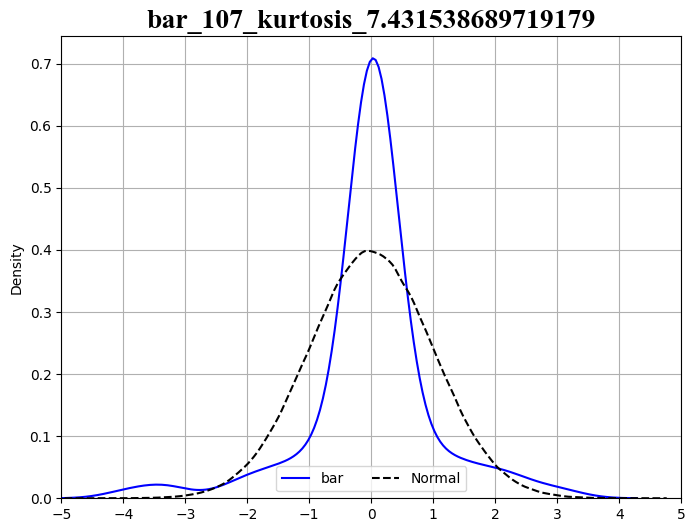

In [50]:
from custom_indicators.utils.plot import plot_kde

merged_bar = build_bar_by_threshold_less_than(
    candles[90:], df["res"].tolist(), 0.5, reverse=False
)

plot_kde(merged_bar[:, 2])

In [51]:
from jesse.utils import numpy_candles_to_dataframe
from lightweight_charts import Chart

df_merged_bar = numpy_candles_to_dataframe(merged_bar)
df_merged_bar.head()

chart = Chart()
chart.set(df_merged_bar[["date", "open", "high", "low", "close", "volume"]])
chart.show(block=True)


RuntimeError: asyncio.run() cannot be called from a running event loop